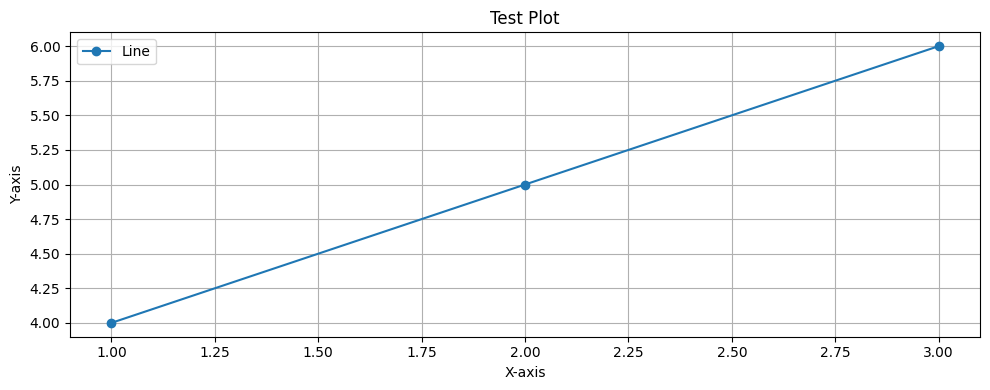

In [1]:


import matplotlib.pyplot as plt

# Create the figure
plt.figure(figsize=(10, 4))
plt.plot([1, 2, 3], [4, 5, 6], marker='o', label='Line')
plt.title("Test Plot")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.grid(True)

plt.tight_layout()  # prevents layout overflow crashes
plt.show()


In [2]:
import os
import cv2
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
train_dataset_path = 'Teeth_Dataset\\Training'
val_dataset_path = 'Teeth_Dataset\\Validation'
test_dataset_path = 'Teeth_Dataset\\Testing'

In [4]:
def read_data(dataset_path): 
    images = []
    labels = []
    for label in os.listdir(dataset_path):
        disease_path = os.path.join(dataset_path, f"{label}")
        for img_name in os.listdir(disease_path):      # return list of the content of the dir like ls -l
            img_path = os.path.join(disease_path, img_name)
            # img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # black or white not RGB
            img_bgr = cv2.imread(img_path)
            # Convert from BGR to RGB
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            images.append(img_rgb)
            labels.append(label)
    return images, labels

In [5]:
train_images, train_labels = read_data(train_dataset_path)
val_images, val_labels = read_data(val_dataset_path)
test_images, test_labels = read_data(test_dataset_path)

In [6]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

val_images = np.array(val_images)
val_labels = np.array(val_labels)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

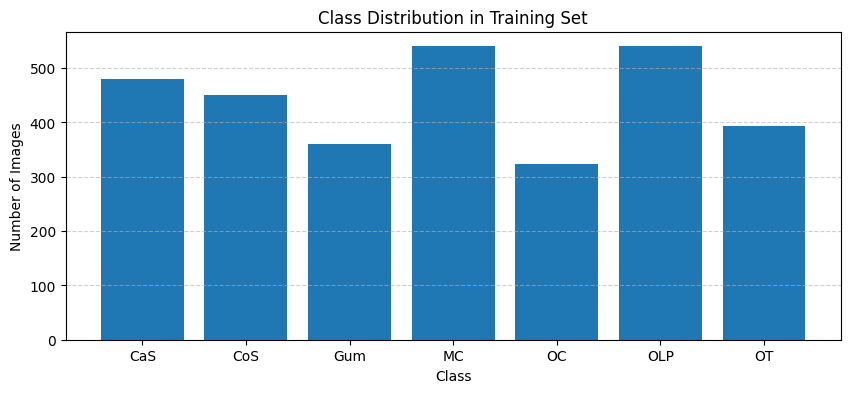

In [7]:
label_counts = Counter(train_labels)
plt.figure(figsize=(10, 4))
plt.bar(label_counts.keys(), label_counts.values())
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

In [8]:
print(train_images.shape)

(3087, 256, 256, 3)


In [9]:
def compute_mean(images):
    images = np.array(images)
    images = images / 255.0  

    mean = images.mean(axis=(0, 1, 2))
    std = images.std(axis=(0, 1, 2))

    return mean, std

In [39]:
# train_mean, train_std = compute_mean(train_images)
# val_mean, val_std = compute_mean(val_images)
# test_mean, test_std = compute_mean(test_images)

train_mean, train_std = np.load("train_mean.npy"), np.load("train_std.npy")
val_mean, val_std = np.load("val_mean.npy"), np.load("val_std.npy")
test_mean, test_std = np.load("test_mean.npy"), np.load("test_std.npy")

In [51]:
augment = transforms.Compose([
    transforms.ToPILImage(),  # This converts a NumPy array or Tensor to a PIL Image since most
                              # torchvision.transforms (like RandomRotation, RandomCrop, etc.) only work on PIL images, not raw NumPy arrays.
    
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05), # Randomly adds or subtracts up to 30% of the brightness, contrast
                                                                                   # and saturation, Randomly shifts the hue (color tone) within ±5%
                                                                                   #  of the hue spectrum.
    
    transforms.RandomHorizontalFlip(), # mirroring
    transforms.RandomRotation(15), # This randomly rotates the image by a value between -15° and +15°
    transforms.ToTensor(),   # scaling the data pixel/255 [0,1]
    transforms.Normalize(train_mean, train_std)  # normalizing the data (pixel-mean)/std
])

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

val_transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize(val_mean, val_std) 
])

test_transfrom = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize(test_mean, test_std) 
])


In [12]:
class DentalDataset(Dataset):
    def __init__(self, images, labels, minority_classes, augment_transform, standard_transform):
        self.images = images              
        self.labels = labels             
        self.minority_classes = minority_classes
        self.augment_transform = augment_transform
        self.standard_transform = standard_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):  # Each time the model requests a batch:
                                # __getitem__() is called for each index in the batch
                                # If that sample belongs to a minority class, it goes through augment_transform
                                # Otherwise, it goes through standard_transform
        img = self.images[idx]
        label = self.labels[idx]

       
        if label in self.minority_classes:
            img = self.augment_transform(img)
        else:
            img = self.standard_transform(img)

        return img, label


In [13]:
minority_classes = ['OC', 'Gum', 'OT', 'CoS', 'CaS']
train_dataset = DentalDataset(
    images=train_images,
    labels=train_labels,
    minority_classes=minority_classes,
    augment_transform=augment,
    standard_transform=train_transform
)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_images = [val_transform(img) for img in val_images]
test_images = [test_transfrom(img) for img in test_images]

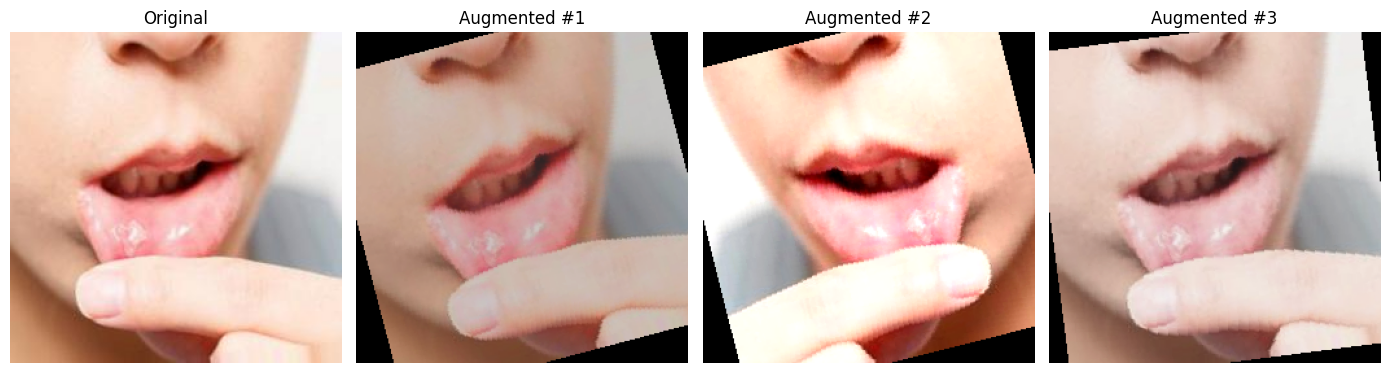

In [67]:
img = train_images[0]  # example RGB image (256, 256, 3), dtype uint8

unNormalized_augment = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

fig, axes = plt.subplots(1, 4, figsize=(14, 4))

axes[0].imshow(img)
axes[0].set_title("Original")
axes[0].axis('off')

for i in range(1, 4):
    aug = unNormalized_augment(img).permute(1, 2, 0).numpy()  # After .ToTensor this is the shape (C, H, W).
                                                              # While this is the shape (H, W, C) imshow can handle so permute is needed tp reorder
    axes[i].imshow(aug)
    axes[i].set_title(f"Augmented #{i}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()
